In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import time
from sklearn.linear_model import LinearRegression

def apply_lowpass_filter(data, high_freq, fs):
    filtered_data = np.zeros_like(data)
    for i in range(data.shape[1]):
        b, a = signal.butter(1, high_freq / (0.5 * fs), 'lowpass')
        zi = signal.lfilter_zi(b, a)
        filtered_data[:, i], _ = signal.lfilter(b, a, data[:, i], zi=zi*data[0, i])
    return filtered_data

def apply_highpass_filter(data, high_freq, fs):
    filtered_data = np.zeros_like(data)
    for i in range(data.shape[1]):
        b, a = signal.butter(1, high_freq / (0.5 * fs), 'highpass')
        zi = signal.lfilter_zi(b, a)
        filtered_data[:, i], _ = signal.lfilter(b, a, data[:, i], zi=zi*data[0, i])
    return filtered_data

def apply_highpass_filter_1(data, high_freq, fs):
    filtered_data = np.zeros_like(data)
    b, a = signal.butter(1, high_freq / (0.5 * fs), 'highpass')
    zi = signal.lfilter_zi(b, a)
    filtered_data[:], _ = signal.lfilter(b, a, data[:], zi=zi*data[0])
    return filtered_data


def apply_bandpass_filter(data, low_freq, high_freq, fs):
    filtered_data = np.zeros_like(data)
    for i in range(data.shape[1]):
        b, a = signal.butter(1, [low_freq / (0.5 * fs), high_freq / (0.5 * fs)], 'bandpass')
        zi = signal.lfilter_zi(b, a)
        filtered_data[:, i], _ = signal.lfilter(b, a, data[:, i], zi=zi*data[0, i])
    return filtered_data

def rescale_array(array1,array2):
    scaled_array=np.zeros_like(array1)
    for i in range(array1.shape[1]):
        new_min=np.min(array1[:,i])
        new_max=np.max(array1[:,i])
        min_val = np.min(array2[:,i])
        max_val = np.max(array2[:,i])
        scaled_array[:,i] = (array2[:,i] - min_val) * (new_max - new_min) / (max_val - min_val) + new_min
    return scaled_array

def rescale_array1(array1,array2):
    scaled_array=np.zeros_like(array1)
    new_min=np.min(array1)
    new_max=np.max(array1)
    min_val = np.min(array2)
    max_val = np.max(array2)
    scaled_array = (array2 - min_val) * (new_max - new_min) / (max_val - min_val) + new_min
    return scaled_array

def apply_lowpass_filter_realtime(data_point, b, a, zi):
    start_time = time.time()  # 记录开始时间
    filtered_data_point, zi = signal.lfilter(b, a, [data_point], zi=zi)
    end_time = time.time()  # 记录结束时间
    filter_time = end_time - start_time  # 计算滤波时间
    return filtered_data_point[0], zi, filter_time 

def apply_highpass_filter_realtime(data_point, b, a, zi):
    start_time = time.time()  # 记录开始时间
    filtered_data_point, zi = signal.lfilter(b, a, [data_point], zi=zi)
    end_time = time.time()  # 记录结束时间
    filter_time = end_time - start_time  # 计算滤波时间
    return filtered_data_point[0], zi, filter_time

class CustomLinearRegression:
    def __init__(self):
        self.slope = None
        self.intercept = None

    def fit(self, X, y):
        X = np.column_stack((np.arange(100).reshape(-1, 1), np.ones_like(np.arange(100).reshape(-1, 1)))) # Add column of ones for intercept
        self.coefficients = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)
        self.slope = self.coefficients[0]
        self.intercept = self.coefficients[1]

    def predict(self, X):
        return (X * self.slope + self.intercept).reshape(-1)

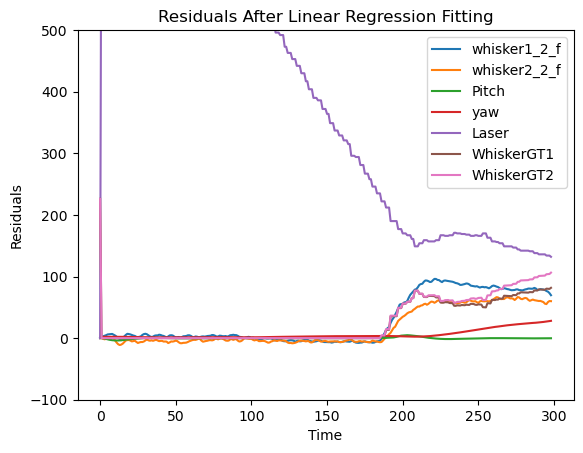

In [85]:
#取前300
data = pd.read_csv('data/20240319/fail1.csv')
pressure = data.iloc[1:300, 7:13].values
laser = data.iloc[1:300, -1].values
yaw = data.iloc[1:300, -3].values
position=data.iloc[1:300,1:4].values
velocity=data.iloc[1:300,4:7].values
whiskergt1=laser+25*np.tan(np.radians(yaw))
whiskergt2=laser-25*np.tan(np.radians(yaw))
whiskergt1 = np.where(whiskergt1 > 227, 0, 227 - whiskergt1)
whiskergt2 = np.where(whiskergt2 > 225, 0, 225 - whiskergt2)
pitch = data.iloc[1:300, -2].values
# 时间步长
time_steps = np.arange(len(pressure))

# 创建线性回归模型
model = CustomLinearRegression()

# 初始化残差数组
residuals = np.zeros_like(pressure)

# 拟合前100个数据点的压力数据
for i in range(pressure.shape[1]):
    model.fit(time_steps[0:100], pressure[0:100, i])
    predicted_pressure = model.predict(time_steps)
    residuals[:, i] = pressure[:, i] - predicted_pressure

filtered_pressure = apply_bandpass_filter(residuals,0.05,3,50)


# plt.plot(residuals[:, 0] , label=f"whisker1_1")
# plt.plot(residuals[:, 1] , label=f"whisker1_2")
# plt.plot(residuals[:, 2] , label=f"whisker1_3")
# # plt.plot(residuals[:, 3] , label=f"whisker2_1")
# plt.plot(residuals[:, 4] , label=f"whisker2_2")
# plt.plot(residuals[:, 5] , label=f"whisker2_3")

plt.plot(filtered_pressure[:, 1] , label=f"whisker1_2_f")
plt.plot(filtered_pressure[:, 4] , label=f"whisker2_2_f")
# plt.plot(filtered_pressure[:, 3] , label=f"whisker2_1_f")
# plt.plot(filtered_pressure[:, 5] , label=f"whisker2_3_f")
# 绘制其他数据
plt.plot(pitch, label="Pitch")
plt.plot(yaw, label="yaw")
plt.plot(laser, label="Laser")
plt.plot(whiskergt1, label="WhiskerGT1")
plt.plot(whiskergt2, label="WhiskerGT2")
plt.legend()
plt.xlabel("Time")
plt.ylabel("Residuals")
plt.ylim(-100, 500)
plt.title("Residuals After Linear Regression Fitting")
plt.show()

new_data = pd.DataFrame({
    'whisker1_1': filtered_pressure[:,0],
    'whisker1_2': filtered_pressure[:,1],
    'whisker1_3': filtered_pressure[:,2],
    'whisker2_1': filtered_pressure[:,3],
    'whisker2_2': filtered_pressure[:,4],
    'whisker2_3': filtered_pressure[:,5],
    'WhiskerGT1': whiskergt1,
    'WhiskerGT2': whiskergt2,
    'laser': laser,
    'yaw': yaw,
    'pitch': pitch,
    'positionX': position[:,0],
    'positionY': position[:,1],
    'positionZ': position[:,2],
    'velocityX': velocity[:,0],
    'velocityY': velocity[:,1],
    'velocityZ': velocity[:,2]
})
new_data.to_csv('dataanalyse/0319/data1.csv', index=False)

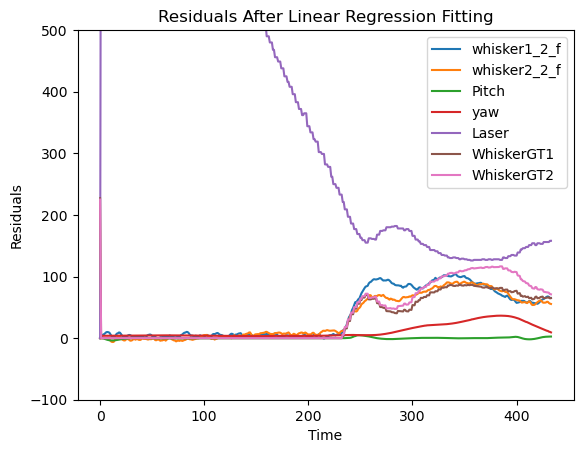

In [86]:
#取前435
data = pd.read_csv('data/20240319/0-200work.csv')
pressure = data.iloc[1:435, 7:13].values
laser = data.iloc[1:435, -1].values
yaw = data.iloc[1:435, -3].values
position=data.iloc[1:435,1:4].values
velocity=data.iloc[1:435,4:7].values
whiskergt1=laser+25*np.tan(np.radians(yaw))
whiskergt2=laser-25*np.tan(np.radians(yaw))
whiskergt1 = np.where(whiskergt1 > 227, 0, 227 - whiskergt1)
whiskergt2 = np.where(whiskergt2 > 225, 0, 225 - whiskergt2)
pitch = data.iloc[1:435, -2].values
# 时间步长
time_steps = np.arange(len(pressure))

# 创建线性回归模型
model = CustomLinearRegression()

# 初始化残差数组
residuals = np.zeros_like(pressure)

# 拟合前100个数据点的压力数据
for i in range(pressure.shape[1]):
    model.fit(time_steps[0:100], pressure[0:100, i])
    predicted_pressure = model.predict(time_steps)
    residuals[:, i] = pressure[:, i] - predicted_pressure

filtered_pressure = apply_bandpass_filter(residuals,0.05,3,50)


# plt.plot(residuals[:, 0] , label=f"whisker1_1")
# plt.plot(residuals[:, 1] , label=f"whisker1_2")
# plt.plot(residuals[:, 2] , label=f"whisker1_3")
# # plt.plot(residuals[:, 3] , label=f"whisker2_1")
# plt.plot(residuals[:, 4] , label=f"whisker2_2")
# plt.plot(residuals[:, 5] , label=f"whisker2_3")

plt.plot(filtered_pressure[:, 1] , label=f"whisker1_2_f")
plt.plot(filtered_pressure[:, 4] , label=f"whisker2_2_f")
# plt.plot(filtered_pressure[:, 3] , label=f"whisker2_1_f")
# plt.plot(filtered_pressure[:, 5] , label=f"whisker2_3_f")
# 绘制其他数据
plt.plot(pitch, label="Pitch")
plt.plot(yaw, label="yaw")
plt.plot(laser, label="Laser")
plt.plot(whiskergt1, label="WhiskerGT1")
plt.plot(whiskergt2, label="WhiskerGT2")
plt.legend()
plt.xlabel("Time")
plt.ylabel("Residuals")
plt.ylim(-100, 500)
plt.title("Residuals After Linear Regression Fitting")
plt.show()

new_data = pd.DataFrame({
    'whisker1_1': filtered_pressure[:,0],
    'whisker1_2': filtered_pressure[:,1],
    'whisker1_3': filtered_pressure[:,2],
    'whisker2_1': filtered_pressure[:,3],
    'whisker2_2': filtered_pressure[:,4],
    'whisker2_3': filtered_pressure[:,5],
    'WhiskerGT1': whiskergt1,
    'WhiskerGT2': whiskergt2,
    'laser': laser,
    'yaw': yaw,
    'pitch': pitch,
    'positionX': position[:,0],
    'positionY': position[:,1],
    'positionZ': position[:,2],
    'velocityX': velocity[:,0],
    'velocityY': velocity[:,1],
    'velocityZ': velocity[:,2]
})
new_data.to_csv('dataanalyse/0319/data2.csv', index=False)

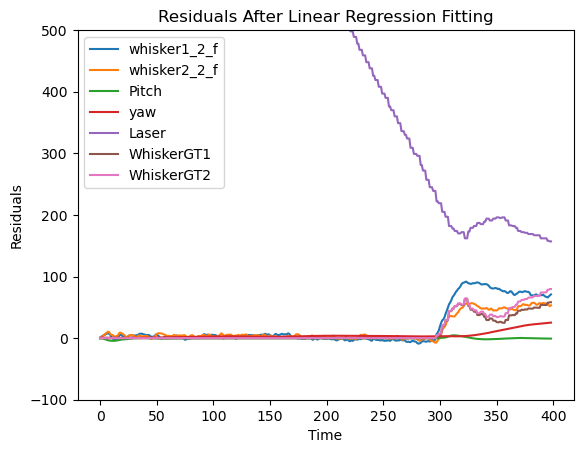

In [87]:
#取前400
data = pd.read_csv('data/20240319/fail5.csv')
pressure = data.iloc[1:400, 7:13].values
laser = data.iloc[1:400, -1].values
yaw = data.iloc[1:400, -3].values
position=data.iloc[1:400,1:4].values
velocity=data.iloc[1:400,4:7].values
whiskergt1=laser+25*np.tan(np.radians(yaw))
whiskergt2=laser-25*np.tan(np.radians(yaw))
whiskergt1 = np.where(whiskergt1 > 227, 0, 227 - whiskergt1)
whiskergt2 = np.where(whiskergt2 > 225, 0, 225 - whiskergt2)
pitch = data.iloc[1:400, -2].values
# 时间步长
time_steps = np.arange(len(pressure))

# 创建线性回归模型
model = CustomLinearRegression()

# 初始化残差数组
residuals = np.zeros_like(pressure)

# 拟合前100个数据点的压力数据
for i in range(pressure.shape[1]):
    model.fit(time_steps[0:100], pressure[0:100, i])
    predicted_pressure = model.predict(time_steps)
    residuals[:, i] = pressure[:, i] - predicted_pressure

filtered_pressure = apply_bandpass_filter(residuals,0.05,3,50)


# plt.plot(residuals[:, 0] , label=f"whisker1_1")
# plt.plot(residuals[:, 1] , label=f"whisker1_2")
# plt.plot(residuals[:, 2] , label=f"whisker1_3")
# # plt.plot(residuals[:, 3] , label=f"whisker2_1")
# plt.plot(residuals[:, 4] , label=f"whisker2_2")
# plt.plot(residuals[:, 5] , label=f"whisker2_3")

plt.plot(filtered_pressure[:, 1] , label=f"whisker1_2_f")
plt.plot(filtered_pressure[:, 4] , label=f"whisker2_2_f")
# plt.plot(filtered_pressure[:, 3] , label=f"whisker2_1_f")
# plt.plot(filtered_pressure[:, 5] , label=f"whisker2_3_f")
# 绘制其他数据
plt.plot(pitch, label="Pitch")
plt.plot(yaw, label="yaw")
plt.plot(laser, label="Laser")
plt.plot(whiskergt1, label="WhiskerGT1")
plt.plot(whiskergt2, label="WhiskerGT2")
plt.legend()
plt.xlabel("Time")
plt.ylabel("Residuals")
plt.ylim(-100, 500)
plt.title("Residuals After Linear Regression Fitting")
plt.show()

new_data = pd.DataFrame({
    'whisker1_1': filtered_pressure[:,0],
    'whisker1_2': filtered_pressure[:,1],
    'whisker1_3': filtered_pressure[:,2],
    'whisker2_1': filtered_pressure[:,3],
    'whisker2_2': filtered_pressure[:,4],
    'whisker2_3': filtered_pressure[:,5],
    'WhiskerGT1': whiskergt1,
    'WhiskerGT2': whiskergt2,
    'laser': laser,
    'yaw': yaw,
    'pitch': pitch,
    'positionX': position[:,0],
    'positionY': position[:,1],
    'positionZ': position[:,2],
    'velocityX': velocity[:,0],
    'velocityY': velocity[:,1],
    'velocityZ': velocity[:,2]
})
new_data.to_csv('dataanalyse/0319/data3.csv', index=False)

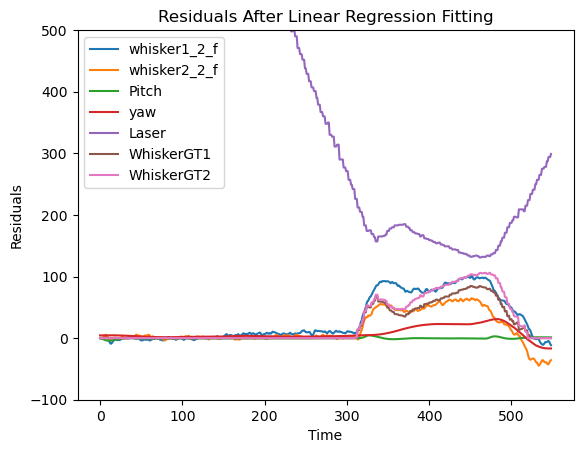

In [88]:
#取前550
data = pd.read_csv('data/20240319/hit2-threshold20.csv')
pressure = data.iloc[1:550, 7:13].values
laser = data.iloc[1:550, -1].values
yaw = data.iloc[1:550, -3].values
position=data.iloc[1:550,1:4].values
velocity=data.iloc[1:550,4:7].values
whiskergt1=laser+25*np.tan(np.radians(yaw))
whiskergt2=laser-25*np.tan(np.radians(yaw))
whiskergt1 = np.where(whiskergt1 > 227, 0, 227 - whiskergt1)
whiskergt2 = np.where(whiskergt2 > 225, 0, 225 - whiskergt2)
pitch = data.iloc[1:550, -2].values
# 时间步长
time_steps = np.arange(len(pressure))

# 创建线性回归模型
model = CustomLinearRegression()

# 初始化残差数组
residuals = np.zeros_like(pressure)

# 拟合前100个数据点的压力数据
for i in range(pressure.shape[1]):
    model.fit(time_steps[0:100], pressure[0:100, i])
    predicted_pressure = model.predict(time_steps)
    residuals[:, i] = pressure[:, i] - predicted_pressure

filtered_pressure = apply_bandpass_filter(residuals,0.05,3,50)


# plt.plot(residuals[:, 0] , label=f"whisker1_1")
# plt.plot(residuals[:, 1] , label=f"whisker1_2")
# plt.plot(residuals[:, 2] , label=f"whisker1_3")
# # plt.plot(residuals[:, 3] , label=f"whisker2_1")
# plt.plot(residuals[:, 4] , label=f"whisker2_2")
# plt.plot(residuals[:, 5] , label=f"whisker2_3")

plt.plot(filtered_pressure[:, 1] , label=f"whisker1_2_f")
plt.plot(filtered_pressure[:, 4] , label=f"whisker2_2_f")
# plt.plot(filtered_pressure[:, 3] , label=f"whisker2_1_f")
# plt.plot(filtered_pressure[:, 5] , label=f"whisker2_3_f")
# 绘制其他数据
plt.plot(pitch, label="Pitch")
plt.plot(yaw, label="yaw")
plt.plot(laser, label="Laser")
plt.plot(whiskergt1, label="WhiskerGT1")
plt.plot(whiskergt2, label="WhiskerGT2")
plt.legend()
plt.xlabel("Time")
plt.ylabel("Residuals")
plt.ylim(-100, 500)
plt.title("Residuals After Linear Regression Fitting")
plt.show()

new_data = pd.DataFrame({
    'whisker1_1': filtered_pressure[:,0],
    'whisker1_2': filtered_pressure[:,1],
    'whisker1_3': filtered_pressure[:,2],
    'whisker2_1': filtered_pressure[:,3],
    'whisker2_2': filtered_pressure[:,4],
    'whisker2_3': filtered_pressure[:,5],
    'WhiskerGT1': whiskergt1,
    'WhiskerGT2': whiskergt2,
    'laser': laser,
    'yaw': yaw,
    'pitch': pitch,
    'positionX': position[:,0],
    'positionY': position[:,1],
    'positionZ': position[:,2],
    'velocityX': velocity[:,0],
    'velocityY': velocity[:,1],
    'velocityZ': velocity[:,2]
})
new_data.to_csv('dataanalyse/0319/data4.csv', index=False)

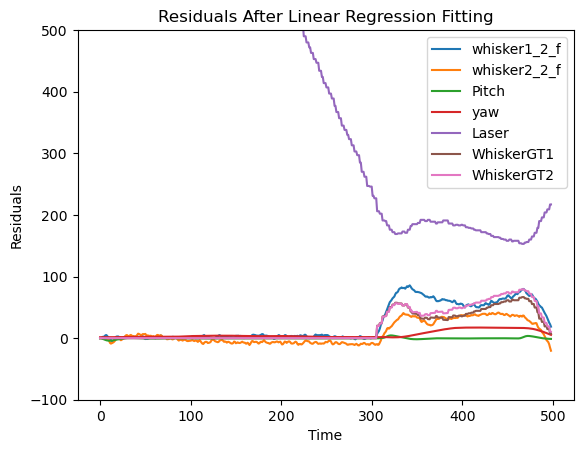

In [89]:
#取前500
data = pd.read_csv('data/20240319/hit1-threshold20.csv')
pressure = data.iloc[1:500, 7:13].values
laser = data.iloc[1:500, -1].values
yaw = data.iloc[1:500, -3].values
position=data.iloc[1:500,1:4].values
velocity=data.iloc[1:500,4:7].values
whiskergt1=laser+25*np.tan(np.radians(yaw))
whiskergt2=laser-25*np.tan(np.radians(yaw))
whiskergt1 = np.where(whiskergt1 > 227, 0, 227 - whiskergt1)
whiskergt2 = np.where(whiskergt2 > 225, 0, 225 - whiskergt2)
pitch = data.iloc[1:500, -2].values
# 时间步长
time_steps = np.arange(len(pressure))

# 创建线性回归模型
model = CustomLinearRegression()

# 初始化残差数组
residuals = np.zeros_like(pressure)

# 拟合前100个数据点的压力数据
for i in range(pressure.shape[1]):
    model.fit(time_steps[0:100], pressure[0:100, i])
    predicted_pressure = model.predict(time_steps)
    residuals[:, i] = pressure[:, i] - predicted_pressure

filtered_pressure = apply_bandpass_filter(residuals,0.05,3,50)


# plt.plot(residuals[:, 0] , label=f"whisker1_1")
# plt.plot(residuals[:, 1] , label=f"whisker1_2")
# plt.plot(residuals[:, 2] , label=f"whisker1_3")
# # plt.plot(residuals[:, 3] , label=f"whisker2_1")
# plt.plot(residuals[:, 4] , label=f"whisker2_2")
# plt.plot(residuals[:, 5] , label=f"whisker2_3")

plt.plot(filtered_pressure[:, 1] , label=f"whisker1_2_f")
plt.plot(filtered_pressure[:, 4] , label=f"whisker2_2_f")
# plt.plot(filtered_pressure[:, 3] , label=f"whisker2_1_f")
# plt.plot(filtered_pressure[:, 5] , label=f"whisker2_3_f")
# 绘制其他数据
plt.plot(pitch, label="Pitch")
plt.plot(yaw, label="yaw")
plt.plot(laser, label="Laser")
plt.plot(whiskergt1, label="WhiskerGT1")
plt.plot(whiskergt2, label="WhiskerGT2")
plt.legend()
plt.xlabel("Time")
plt.ylabel("Residuals")
plt.ylim(-100, 500)
plt.title("Residuals After Linear Regression Fitting")
plt.show()

new_data = pd.DataFrame({
    'whisker1_1': filtered_pressure[:,0],
    'whisker1_2': filtered_pressure[:,1],
    'whisker1_3': filtered_pressure[:,2],
    'whisker2_1': filtered_pressure[:,3],
    'whisker2_2': filtered_pressure[:,4],
    'whisker2_3': filtered_pressure[:,5],
    'WhiskerGT1': whiskergt1,
    'WhiskerGT2': whiskergt2,
    'laser': laser,
    'yaw': yaw,
    'pitch': pitch,
    'positionX': position[:,0],
    'positionY': position[:,1],
    'positionZ': position[:,2],
    'velocityX': velocity[:,0],
    'velocityY': velocity[:,1],
    'velocityZ': velocity[:,2]
})
new_data.to_csv('dataanalyse/0319/data5.csv', index=False)